In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IA.utils import mapping, parameter_range
from scipy import stats
from pathlib import Path
import math
import swifter
from sklearn import metrics
from statsmodels.sandbox.stats.runs import mcnemar
plt.style.reload_library()
plt.style.use(['science'])

In [2]:
!ls -lah analysis/not_uploaded/IA2NIMA/AVA/

total 92M
drwxr-xr-x 2 janpf janpf 4.0K Nov 17 23:12 .
drwxr-xr-x 3 janpf janpf 4.0K Nov 11 18:07 ..
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.None.change_regress.epoch-0.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.None.change_regress.epoch-126.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.None.change_regress.epoch-149.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.None.change_regress.epoch-21.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.None.change_regress.epoch-22.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.imagenet.epoch-0.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.imagenet.epoch-14.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.imagenet.epoch-149.pth.txt
-rw-r--r-- 1 janpf janpf 2.8M Nov 12 16:04 .scratch.ckpts.IA2NIMA.AVA.image

In [3]:
df_l = []
for p in Path("analysis/not_uploaded/IA2NIMA/AVA/").iterdir():
    tmp = pd.read_csv(p)
    tmp["scores"] = tmp["scores"].swifter.apply(eval)
    tmp["score"] = tmp["scores"].swifter.apply(lambda row: sum([row[i] * (i+1) for i in range(len(row))]))
    tmp["img"] = tmp["img"].swifter.apply(lambda row: row.split(".")[0])
    tmp["quality"] = tmp["score"].apply(lambda row: 1 if row > 5 else 0)
    tmp["quality"] = tmp["quality"].astype(int)
    tmp["img"] = tmp["img"].astype(int)

    tmp.drop(columns=["scores"], inplace=True)
    tmp = tmp.rename(columns={"score":"score_" + p.stem.split("AVA.")[1], "quality": "quality_" + p.stem.split("AVA.")[1]})

    tmp = tmp.set_index("img")
    df_l.append(tmp)

df = df_l[0].join(df_l[1:])

Pandas Apply: 100%|██████████| 12818/12818 [00:00<00:00, 809836.09it/s]


In [4]:
gt = pd.read_csv("analysis/not_uploaded/AVA_gt.txt", sep=" ").drop(columns=["Unnamed: 0", "semanticTagID1", "semanticTagID2", "challengeID"])

In [5]:
gt["votes"] = gt.apply(lambda row: sum(list(row)[1:]), axis=1)
gt["gt_score"] = gt.apply(lambda row: sum([val * (i + 1) for i, val in enumerate(list(row)[1:-1])]), axis=1)
gt["gt_score"] = gt.apply(lambda row: row.gt_score / row.votes, axis=1)
gt["gt_quality"] = gt["gt_score"].apply(lambda row: 1 if row > 5 else 0)
gt["img"] = gt["img"].astype(int)

gt = gt[["img","gt_score", "gt_quality"]]
gt = gt.set_index("img")

In [6]:
df = gt.join(df).dropna().drop_duplicates()
df

,gt_score,gt_quality,score_one.change_class.epoch-0.pth,quality_one.change_class.epoch-0.pth,score_one.change_class.epoch-149.pth,quality_one.change_class.epoch-149.pth,score_one.change_regress.epoch-77.pth,quality_one.change_regress.epoch-77.pth,score_None.change_regress.epoch-21.pth,quality_None.change_regress.epoch-21.pth,...,score_one.epoch-96.pth,quality_one.epoch-96.pth,score_one.change_class.epoch-19.pth,quality_one.change_class.epoch-19.pth,score_imagenet.epoch-14.pth,quality_imagenet.epoch-14.pth,score_three.epoch-14.pth,quality_three.epoch-14.pth,score_one.epoch-0.pth,quality_one.epoch-0.pth
img,,,,,,,,,,,,,,,,,,,,,
953844,5.914062,1,5.435197,1.0,5.457176,1.0,5.482815,1.0,5.498982,1.0,...,5.531028,1.0,5.420652,1.0,5.318886,1.0,5.521613,1.0,5.396214,1.0
953283,6.755556,1,5.493105,1.0,5.857566,1.0,5.857421,1.0,5.449551,1.0,...,5.906423,1.0,5.479660,1.0,5.650019,1.0,5.477555,1.0,5.381501,1.0
954116,5.541985,1,4.604829,0.0,4.431028,0.0,4.396991,0.0,4.542896,0.0,...,4.437678,0.0,4.473223,0.0,4.955961,0.0,4.839361,0.0,4.614480,0.0
953780,5.041667,1,5.636556,1.0,5.670701,1.0,5.681622,1.0,5.556524,1.0,...,5.689779,1.0,5.699583,1.0,5.578553,1.0,5.528334,1.0,5.553999,1.0
953582,5.943548,1,5.491844,1.0,5.841414,1.0,5.847270,1.0,5.420136,1.0,...,5.855429,1.0,5.481449,1.0,5.501658,1.0,5.451525,1.0,5.452984,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870778,5.722467,1,5.435381,1.0,5.764147,1.0,5.755226,1.0,5.348412,1.0,...,5.734670,1.0,5.466403,1.0,5.449655,1.0,5.432651,1.0,5.376922,1.0
869976,5.199115,1,5.291705,1.0,5.458912,1.0,5.437215,1.0,5.303173,1.0,...,5.422185,1.0,5.301169,1.0,5.287876,1.0,5.289424,1.0,5.417442,1.0
57275,6.492248,1,5.299766,1.0,5.581259,1.0,5.489268,1.0,5.400688,1.0,...,5.528252,1.0,5.275638,1.0,5.504054,1.0,5.297915,1.0,5.332044,1.0


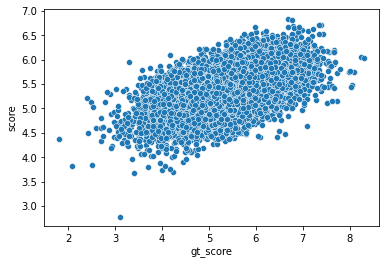

In [26]:
sns.scatterplot(data=df.rename(columns={"score_one.change_regress.epoch-77.pth":"score"}), x="gt_score", y="score")

([<matplotlib.axis.XTick at 0x7fa042aba5e0>,
 <a list of 10 Text major ticklabel objects>)

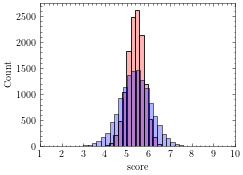

In [52]:
sns.histplot(x=df.rename(columns={"score_one.change_regress.epoch-77.pth":"score"})["score"], ax=plt.gcf().gca(), color="red", binwidth=0.2, alpha=0.3)
sns.histplot(x=df.rename(columns={"gt_score":"ground truth"})["ground truth"], ax=plt.gcf().gca(), color="blue", binwidth=0.2, alpha=0.3)
plt.xlim(1,10)
plt.xticks(range(1,11))

In [7]:
for score in sorted(df.columns):
    if "gt" in score or not "score" in score:
        continue
    if "epoch-0" in score:
        print()
        print(score)
        print("LCC :", stats.pearsonr(df["gt_score"], df[score])[0])
        print("SRCC:", stats.spearmanr(df["gt_score"], df[score])[0])
        print("ACC :", metrics.accuracy_score(df["gt_quality"], df[score.replace("score", "quality")]))
        print("F1  :", metrics.f1_score(df["gt_quality"], df[score.replace("score", "quality")]))


score_None.change_regress.epoch-0.pth
LCC : 0.3849882430105106
SRCC: 0.3726759703852357
ACC : 0.7104072398190046
F1  : 0.8286716514354289

score_imagenet.epoch-0.pth
LCC : 0.4201242495100065
SRCC: 0.4052444145004332
ACC : 0.7103292245280075
F1  : 0.8291538213776285

score_one.change_class.epoch-0.pth
LCC : 0.3814452323023531
SRCC: 0.3679459783517518
ACC : 0.7157902948978
F1  : 0.8307392092180458

score_one.change_regress.epoch-0.pth
LCC : 0.3647101370511038
SRCC: 0.3542329630869461
ACC : 0.7090809798720549
F1  : 0.8280853810336083

score_one.epoch-0.pth
LCC : 0.38264699465973656
SRCC: 0.37114514538500637
ACC : 0.7104072398190046
F1  : 0.8285450346420324

score_three.change_class.epoch-0.pth
LCC : 0.3804607068870273
SRCC: 0.366337496645488
ACC : 0.7156342643158059
F1  : 0.8301728556119834

score_three.epoch-0.pth
LCC : 0.3759446924376585
SRCC: 0.3637605783888563
ACC : 0.7095490716180372
F1  : 0.8281401467940727


In [8]:
for score in sorted(df.columns):
    if "gt" in score or not "score" in score:
        continue
    if "epoch-149" in score:
        print()
        print(score)
        print("LCC :", stats.pearsonr(df["gt_score"], df[score])[0])
        print("SRCC:", stats.spearmanr(df["gt_score"], df[score])[0])
        print("ACC :", metrics.accuracy_score(df["gt_quality"], df[score.replace("score", "quality")]))
        print("F1  :", metrics.f1_score(df["gt_quality"], df[score.replace("score", "quality")]))


score_None.change_regress.epoch-149.pth
LCC : 0.5540258828968079
SRCC: 0.5419693787297942
ACC : 0.7548759556873147
F1  : 0.8427112535042051

score_imagenet.epoch-149.pth
LCC : 0.5490840432277029
SRCC: 0.537131804655928
ACC : 0.7542518333593384
F1  : 0.8417880462079358

score_one.change_class.epoch-149.pth
LCC : 0.5538765170760429
SRCC: 0.5412968490686533
ACC : 0.7539397721953502
F1  : 0.8416030534351143

score_one.change_regress.epoch-149.pth
LCC : 0.5545302719430375
SRCC: 0.5424093373503757
ACC : 0.7572164144172258
F1  : 0.8438534872052184

score_one.epoch-149.pth
LCC : 0.553627960621008
SRCC: 0.5414200897224664
ACC : 0.7550319862693088
F1  : 0.8424485699949824

score_three.change_class.epoch-149.pth
LCC : 0.5538278238103207
SRCC: 0.5411157101227089
ACC : 0.7557341238882821
F1  : 0.8425762984564331

score_three.epoch-149.pth
LCC : 0.5540925718421347
SRCC: 0.5415542241074812
ACC : 0.7569043532532377
F1  : 0.8436370935367322


In [9]:
for score in sorted(df.columns):
    if "gt" in score or not "score" in score:
        continue
    if "epoch-0" in score or "epoch-149" in score:
        continue 
    print()
    print(score)
    print("LCC :", stats.pearsonr(df["gt_score"], df[score])[0])
    print("SRCC:", stats.spearmanr(df["gt_score"], df[score])[0])

    print("ACC :", metrics.accuracy_score(df["gt_quality"], df[score.replace("score", "quality")]))
    print("F1  :", metrics.f1_score(df["gt_quality"], df[score.replace("score", "quality")]))


score_None.change_regress.epoch-126.pth
LCC : 0.5539649058947431
SRCC: 0.5419311884928725
ACC : 0.7550319862693088
F1  : 0.8428271098208029

score_None.change_regress.epoch-21.pth
LCC : 0.3927165157296927
SRCC: 0.38238714082757774
ACC : 0.7146980808238415
F1  : 0.8303724662553922

score_None.change_regress.epoch-22.pth
LCC : 0.4593958002528293
SRCC: 0.447930544039063
ACC : 0.7278046497113434
F1  : 0.8334367689883991

score_imagenet.epoch-14.pth
LCC : 0.4332790675010538
SRCC: 0.41701971390852466
ACC : 0.7206272429396162
F1  : 0.8313950750976976

score_imagenet.epoch-15.pth
LCC : 0.46399542225309515
SRCC: 0.45032750056824883
ACC : 0.7282727414573257
F1  : 0.8335006453463358

score_one.change_class.epoch-19.pth
LCC : 0.3844514600592459
SRCC: 0.3731118391483095
ACC : 0.7173506007177407
F1  : 0.8304394627228903

score_one.change_class.epoch-20.pth
LCC : 0.4153538860539153
SRCC: 0.40379109461164303
ACC : 0.7228116710875332
F1  : 0.8315874294923448

score_one.change_class.epoch-89.pth
LCC : 

In [16]:
from scipy.stats import wilcoxon

In [15]:
signific_df = df[["gt_score", "score_one.change_regress.epoch-77.pth", "score_imagenet.epoch-149.pth"]].rename(columns={"score_one.change_regress.epoch-77.pth": "ours", "score_imagenet.epoch-149.pth":"imagenet"})
signific_df

,gt_score,ours,imagenet
img,,,
953844,5.914062,5.482815,5.458504
953283,6.755556,5.857421,5.847750
954116,5.541985,4.396991,4.549403
953780,5.041667,5.681622,5.690094
953582,5.943548,5.847270,5.793649
...,...,...,...
870778,5.722467,5.755226,5.741371
869976,5.199115,5.437215,5.496664
57275,6.492248,5.489268,5.533040


In [22]:
wilcoxon(signific_df["ours"]-signific_df["gt_score"], signific_df["imagenet"]-signific_df["gt_score"])

WilcoxonResult(statistic=39330606.0, pvalue=3.019121622800845e-05)

In [24]:
wilcoxon(signific_df["ours"]-signific_df["gt_score"], signific_df["imagenet"]-signific_df["gt_score"], alternative="less")

WilcoxonResult(statistic=39330606.0, pvalue=1.5095608114004225e-05)

In [25]:
wilcoxon(signific_df["ours"]-signific_df["gt_score"], signific_df["imagenet"]-signific_df["gt_score"], alternative="greater")

WilcoxonResult(statistic=39330606.0, pvalue=0.999984904391886)